In [1]:
# Core jax
import jax
# from jax.config import config
jax.config.update("jax_enable_x64", True)

import jax.numpy as np
import jax.random as jr

# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl
import dLux.utils as dlu

# Plotting/visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# gonna have to define my own log likelihoods which are analytic contiuations???

from jax.scipy.special import gammaln, xlogy

def poisson_loglike_gamma(k, mu):
    # analytic continuation using gammaln(k+1)
    k = np.asarray(k)
    mu = np.asarray(mu)
    valid = (k >= 0) & np.isfinite(k) & (mu > 0) & np.isfinite(mu)
    logp = xlogy(k, mu) - mu - gammaln(k + 1.0)
    return np.where(valid, logp, -np.inf)

def poisson_loglike_unnormalized(k, mu):
    # returns k*log(mu) - mu  (no normalization constant)
    return xlogy(k, mu) - mu

# define the likelihood function:
def poiss_loglike(pytree, data) -> float:
    """
    Poissonian log likelihood of the pytree given the data. Assumes the pytree
    has a .model() function.

    Parameters
    ----------
    pytree : Base
        Pytree with a .model() function.
    data : Array
        Data to compare the model to.

    Returns
    -------
    log_likelihood : Array
        Log likelihood of the pytree given the data.
    """
    return poisson_loglike_gamma(pytree.model(), data).sum()

plt.rcParams["image.origin"] = 'lower'

In [2]:
from dLuxToliman import ApplyBasisCLIMB, TolimanOpticalSystem, AlphaCen
# Random seed key
key = jr.PRNGKey(8)

# Construct source and layers
# For this to work, best to just keep single wavelength of 585e-9
# Why? Because toliman optical system gives a OPD layer which only corresponds to a pi phase shift at 585 nm
wf_npix = 256 
diameter = 0.125 # This is default of toliman optical system. Can change.

### Can apply these to the input if you just want a clear aperture
m2_diameter = 0
strut_width = 0
###

wavelength = 585e-9

# This is to what degree we undersample Nyquist
nyquist_factor = 4
psf_npix = 256 / nyquist_factor
psf_pixel_scale = nyquist_factor * dlu.rad2arcsec(wavelength/(2*diameter))
oversample = nyquist_factor * 4 # sample at 4x nyquist originally

# Place the source in the centre of the top right from center pixel.
# That's what the position argument does here
source = dl.PointSource(flux=1e6,position=dlu.arcsec2rad(np.array([psf_pixel_scale/2, psf_pixel_scale/2])),wavelengths=np.array([wavelength]))

# Optimisable binary mask
climb_basis = np.load("../xk4/files/basis.npy")
coefficients = 100*jr.normal(key, [len(climb_basis)])
mean_wl = source.wavelengths.mean()

# have to make sure that mean_wl is in meters.
mask_layer = ApplyBasisCLIMB(climb_basis, mean_wl, coefficients)

# Construct instrument
optics = TolimanOpticalSystem(wf_npixels=wf_npix,psf_npixels=psf_npix, mask=mask_layer, 
                              radial_orders=[2, 3], psf_pixel_scale=psf_pixel_scale, oversample=oversample)

# detector layer
detector_layers = [
    (
        'downsample',
        dl.detector_layers.Downsample(oversample)
    )
]

detector = dl.LayeredDetector(layers = detector_layers)
model = dl.Telescope(optics, source, detector)

psf = model.model()

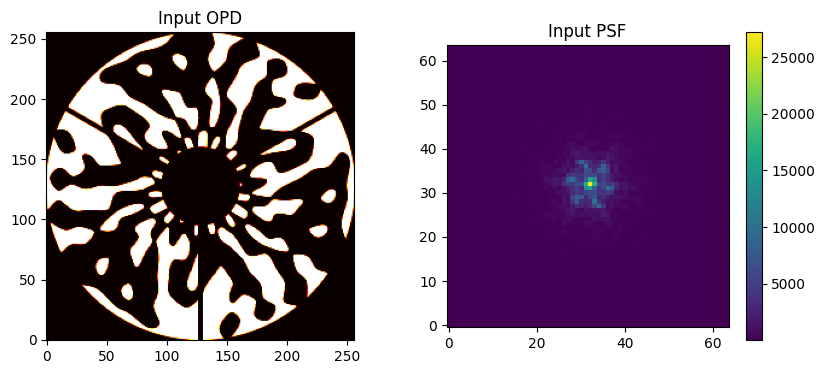

In [3]:
aperture = model.aperture.transmission
mask = model.pupil.get_binary_phase()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(aperture * mask, cmap='hot', origin='lower')
plt.title('Input OPD')
plt.subplot(1, 2, 2)

plt.imshow(psf, origin='lower')
plt.colorbar()
plt.title('Input PSF')
plt.show()

In [4]:
# Marginal params
marginal_params = 'position'

# Loss function
opt_param = 'pupil.coefficients'
@zdx.filter_jit
@zdx.filter_value_and_grad(opt_param)
def fim_loss_func(model, parameters):
    #updating this to work for us
    # define a new field 'data'
    # this is basically like taking the expected value
    data = model.model()
    cov = zdx.covariance_matrix(model, parameters, poiss_loglike, data=data)
    # Loss function: trace of covariance in x and y
    return np.log(np.trace(cov))

In [5]:
%%time
loss, grads = fim_loss_func(model, marginal_params)
print("Initial Loss: {}".format(loss))

Initial Loss: -36.06014411182071
CPU times: user 7.8 s, sys: 249 ms, total: 8.05 s
Wall time: 3.09 s


In [6]:
optim, opt_state = zdx.get_optimiser(model, opt_param, optax.adam(2e1))

losses, models_out = [], [model]
with tqdm(range(80),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = fim_loss_func(model, marginal_params)
        updates, opt_state = optim.update(grads, opt_state)
        model = zdx.apply_updates(model, updates)
        models_out.append(model)
        losses.append(loss)
        t.set_description("Loss: {:.3f}".format(loss)) # update the progress bar

Gradient Descent:   0%|          | 0/80 [00:00<?, ?it/s]

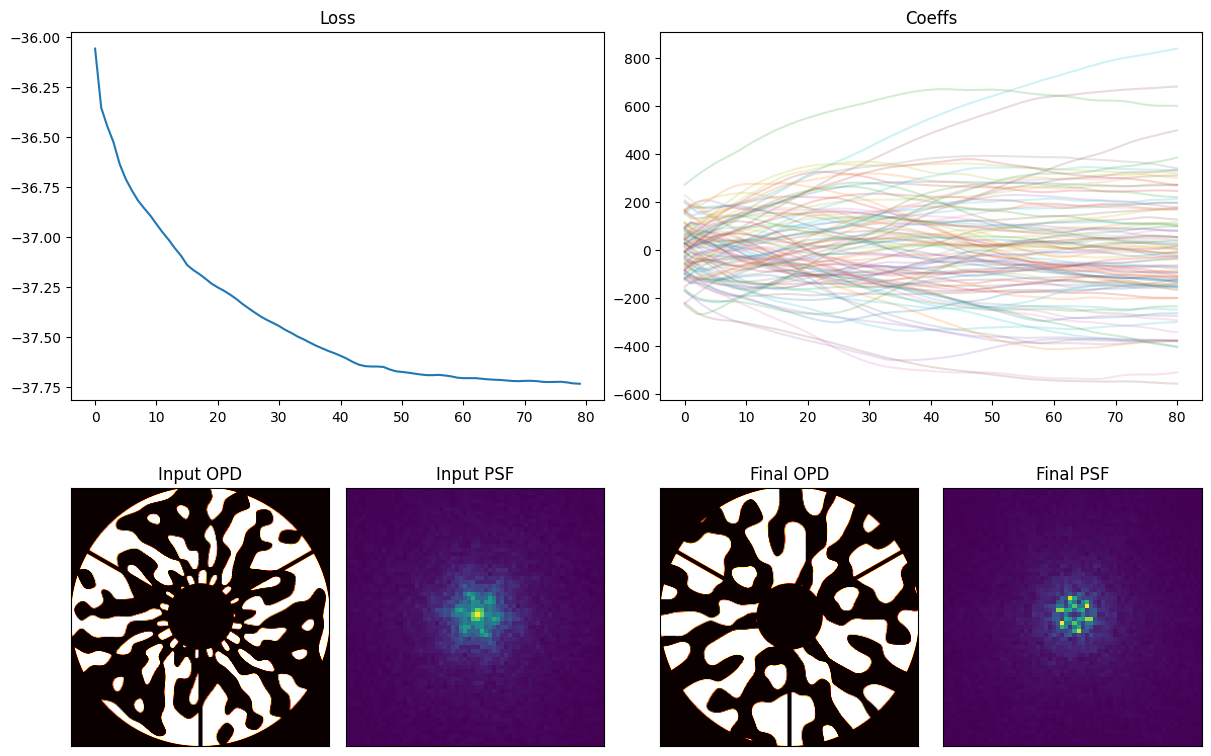

In [7]:
coeffs_out = np.array([model.get(opt_param) for model in models_out])

mosaic = """
         AABB
         CDEF
         """

fig = plt.figure(constrained_layout=True,figsize=(12, 8))
axes = fig.subplot_mosaic(mosaic)

for ax in ['C','D','E','F']:
    axes[ax].set_xticks([])
    axes[ax].set_yticks([])


axes['A'].plot(np.array(losses))
axes['A'].set_title("Loss")

axes['B'].set_title("Coeffs")
axes['B'].plot(coeffs_out[:], alpha=0.2)

mask = models_out[0].pupil.get_binary_phase()
axes['C'].imshow(aperture * mask, cmap='hot')
axes['C'].set_title('Input OPD')

psf_in = models_out[0].model()
axes['D'].imshow(psf_in**0.5)
axes['D'].set_title('Input PSF')

mask = models_out[-1].pupil.get_binary_phase()
axes['E'].imshow(aperture * mask, cmap='hot')
axes['E'].set_title('Final OPD')

psf_out = models_out[-1].model()
axes['F'].imshow(psf_out**0.5)
axes['F'].set_title('Final PSF')

plt.show()

In [8]:
%%time
covs = [zdx.covariance_matrix(model, marginal_params, poiss_loglike, data=model.model()) for model in [models_out[0], models_out[-1]]]

CPU times: user 14.9 s, sys: 1.35 s, total: 16.2 s
Wall time: 9.01 s


In [9]:
# Now we need an "airy covariance" and a "diffuser/defocus covariance"
# As well as the default "Toliman" covariance.

# Tol:
optics_tol = TolimanOpticalSystem(wf_npixels=wf_npix,psf_npixels=psf_npix, psf_pixel_scale=psf_pixel_scale, oversample=oversample)
model_tol = dl.Telescope(optics_tol, source, detector)
data_tol = model_tol.model()
covs_tol = zdx.covariance_matrix(model_tol, marginal_params, poiss_loglike, data=data_tol)

# Airy:
coords = dlu.pixel_coords(wf_npix, diameter)
airy_aperture = dlu.circle(coords, 0.5*diameter)
airy_layers = [
    (
        'aperture',
        dl.TransmissiveLayer(airy_aperture,normalise=True)
    )
]
optics_airy = dl.AngularOpticalSystem(wf_npixels = wf_npix, diameter = diameter, layers=airy_layers,
                                      psf_npixels=psf_npix,psf_pixel_scale=psf_pixel_scale,oversample=oversample)
model_airy = dl.Telescope(optics_airy,source,detector)
data_airy = model_airy.model()
covs_airy = zdx.covariance_matrix(model_airy, marginal_params, poiss_loglike, data=data_airy)

# Zernike defocus
defocus_layers = [
    (
        'aperture',
        dl.TransmissiveLayer(aperture, normalise=True)
    ),
    (
        'defocus',
        dl.AberratedLayer(opd = 0.75*wavelength*dlu.zernike(4,coords,diameter))
    )
]
optics_defocus = dl.AngularOpticalSystem(wf_npixels = wf_npix, diameter = diameter, layers=defocus_layers,
                                      psf_npixels=psf_npix,psf_pixel_scale=psf_pixel_scale,oversample=oversample)
model_defocus = dl.Telescope(optics_defocus, source, detector)
data_defocus = model_defocus.model()
covs_defocus = zdx.covariance_matrix(model_defocus, marginal_params, poiss_loglike, data=data_defocus)

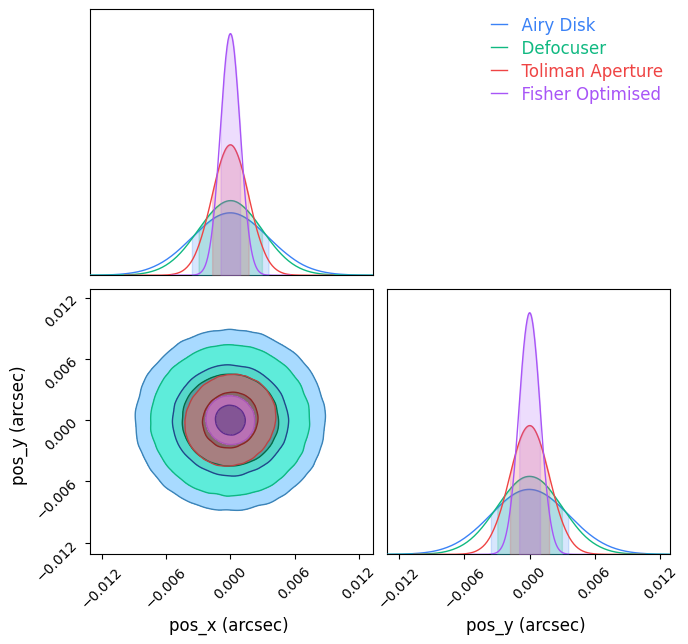

In [10]:
from chainconsumer import ChainConsumer, Chain
param_names = ["pos_x (arcsec)", "pos_y (arcsec)"]
X = np.zeros(len(param_names))

c = ChainConsumer()
# This 'commented out' one is just before optimisation
# c.add_chain(
#     Chain.from_covariance(mean=X, covariance=dlu.rad2arcsec(covs[0]), columns=param_names, name="Initial")
# )

# To convert to arcsec, have to square the conversion factor
cov_to_arcsec = dlu.rad2arcsec(1)**2
c.add_chain(
    Chain.from_covariance(mean=X, covariance=covs_airy*cov_to_arcsec, columns=param_names, name="Airy Disk")
)
c.add_chain(
    Chain.from_covariance(mean=X, covariance=covs_defocus*cov_to_arcsec, columns=param_names, name='Defocuser')
)
c.add_chain(
    Chain.from_covariance(mean=X, covariance=covs_tol*cov_to_arcsec, columns=param_names, name="Toliman Aperture")
)
c.add_chain(
    Chain.from_covariance(mean=X, covariance=covs[1]*cov_to_arcsec, columns=param_names, name="Fisher Optimised")
)

#c.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)
fig = c.plotter.plot()
# Very cool/interesting results!